In [1]:
# If we choose different extinction values, how many candidates would we end up with? 
# This file reads in the extinction table we use, removes our fiducial Av, then applies a new Av to step 5 photometry
# The dered magnitudes are saved over and our candidate selection is then run in a single cell 
# Final values are printed out at the end. 
# Primary Author: Bethany Ludwig 
# Last Updated: March 4 2025 

###########
# Change Av Here    
lmc_Av = 0.38
smc_Av = 0.22
###########

# Fiducial Values, need to divide our table by this to get the extinction coefficients 
lmc_Av0 = 0.38 # Fiducial is 0.38 
smc_Av0 = 0.22 # Fiducial is 0.22 

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import rc
from astropy.coordinates import SkyCoord

#############
# Functions #
#############
def AbsoluteToApparent(AbsoluteMag,distance):
	return AbsoluteMag + 5 * (np.log10(distance/10)) 	

def AssessColor(data_x,data_y,data_x_err,zams_blue,zams_red):
	curve_x = np.array(zams_blue) - np.array(zams_red)
	curve_y = np.array(zams_blue)
	x_zams = np.interp(data_y,np.flip(curve_y,0),np.flip(curve_x,0))

	# Check if it is blue or not
	colors = []
	for i,x in enumerate(data_x):
		# If left of zams than consider it overlap 
		# unless we prove that it is blue within errors
		if x < (x_zams[i]):
			color = 'overlap'

		# If truly left of zams even within errors
		# than blue
		if x < (x_zams[i]-data_x_err[i]):
			color = 'blue'

		# If right of zams than consider it overlap
		# unless we prove that it is red within errors
		if x > x_zams[i]:
			color = 'overlap'

		# If right of zams than red
		if x > x_zams[i] + data_x_err[i]:
			color = 'red'

		# If color is off in narnia or a NaN
		if x < -90 or np.isnan(x):
			color = 'false'

		colors.append(color)
	return colors
def Quad(X,Y):
	return np.sqrt(X**2+Y**2) 
def CombinedErrors(mag_err,std):
	# Calculate everything in quadrature
	combined_errors = Quad(mag_err,std)
	# Replace anything that was nan (due to no std) with just the error
	combined_errors[np.isnan(combined_errors)] = mag_err[np.isnan(combined_errors)]
	return combined_errors
def DistanceToZams(data_x,data_y,zams_blue,zams_red):
	curve_x = np.array(zams_blue) - np.array(zams_red)
	curve_y = np.array(zams_blue)
	x_zams = np.interp(data_y,np.flip(curve_y,0),np.flip(curve_x,0))
	distance = data_x - x_zams
	# If distance is an extreme value make it nan 
	distance[np.abs(distance) > 20] = np.nan
	return distance
def Color(df,zams):
    colors = {
        'uvw2 - b' : df['uvw2_dered'] - df['B_dered'],
        'uvw2 - v' : df['uvw2_dered'] - df['V_dered'],
        'uvw2 - i' : df['uvw2_dered'] - df['I_dered'],
        'uvw1 - b' : df['uvw1_dered'] - df['B_dered'],
        'uvw1 - v' : df['uvw1_dered'] - df['V_dered'],
        'uvw1 - i' : df['uvw1_dered'] - df['I_dered'],
        'uvm2 - b' : df['uvm2_dered'] - df['B_dered'],
        'uvm2 - v' : df['uvm2_dered'] - df['V_dered'],
        'uvm2 - i' : df['uvm2_dered'] - df['I_dered']
    }

    # Combined errors. Quad if both error and std are present otherwise just the error 
    combined_errs = {
        'uvw2_err' : CombinedErrors(df['uvw2_err'], df['uvw2_std']),
        'uvw1_err' : CombinedErrors(df['uvw1_err'], df['uvw1_std']),
        'uvm2_err' : CombinedErrors(df['uvm2_err'], df['uvm2_std']),
    }

    color_errs = {
        'uvw2 - b' : Quad(combined_errs['uvw2_err'] , df['e_B']),
        'uvw2 - v' : Quad(combined_errs['uvw2_err'] , df['e_V']),
        'uvw2 - i' : Quad(combined_errs['uvw2_err'] , df['e_I']),
        'uvw1 - b' : Quad(combined_errs['uvw1_err'] , df['e_B']),
        'uvw1 - v' : Quad(combined_errs['uvw1_err'] , df['e_V']),
        'uvw1 - i' : Quad(combined_errs['uvw1_err'] , df['e_I']),
        'uvm2 - b' : Quad(combined_errs['uvm2_err'] , df['e_B']),
        'uvm2 - v' : Quad(combined_errs['uvm2_err'] , df['e_V']),
        'uvm2 - i' : Quad(combined_errs['uvm2_err'] , df['e_I'])
    }
    color_labels = {              # x             # y                # x_err                # zams_blue  # zams_red
        'uvw2 - b' : AssessColor(colors['uvw2 - b'],df['uvw2_dered'],color_errs['uvw2 - b'],zams['uvw2'],zams['b']),
        'uvw2 - v' : AssessColor(colors['uvw2 - v'],df['uvw2_dered'],color_errs['uvw2 - v'],zams['uvw2'],zams['v']),
        'uvw2 - i' : AssessColor(colors['uvw2 - i'],df['uvw2_dered'],color_errs['uvw2 - i'],zams['uvw2'],zams['i']),
        'uvw1 - b' : AssessColor(colors['uvw1 - b'],df['uvw1_dered'],color_errs['uvw1 - b'],zams['uvw1'],zams['b']),
        'uvw1 - v' : AssessColor(colors['uvw1 - v'],df['uvw1_dered'],color_errs['uvw1 - v'],zams['uvw1'],zams['v']),
        'uvw1 - i' : AssessColor(colors['uvw1 - i'],df['uvw1_dered'],color_errs['uvw1 - i'],zams['uvw1'],zams['i']),
        'uvm2 - b' : AssessColor(colors['uvm2 - b'],df['uvm2_dered'],color_errs['uvm2 - b'],zams['uvm2'],zams['b']),
        'uvm2 - v' : AssessColor(colors['uvm2 - v'],df['uvm2_dered'],color_errs['uvm2 - v'],zams['uvm2'],zams['v']),
        'uvm2 - i' : AssessColor(colors['uvm2 - i'],df['uvm2_dered'],color_errs['uvm2 - i'],zams['uvm2'],zams['i']),

        'uvw2 - b distance' : DistanceToZams(colors['uvw2 - b'],df['uvw2_dered'],zams['uvw2'],zams['b']),
        'uvw2 - v distance' : DistanceToZams(colors['uvw2 - v'],df['uvw2_dered'],zams['uvw2'],zams['v']),
        'uvw2 - i distance' : DistanceToZams(colors['uvw2 - i'],df['uvw2_dered'],zams['uvw2'],zams['i']),
        'uvw1 - b distance' : DistanceToZams(colors['uvw1 - b'],df['uvw1_dered'],zams['uvw1'],zams['b']),
        'uvw1 - v distance' : DistanceToZams(colors['uvw1 - v'],df['uvw1_dered'],zams['uvw1'],zams['v']),
        'uvw1 - i distance' : DistanceToZams(colors['uvw1 - i'],df['uvw1_dered'],zams['uvw1'],zams['i']),
        'uvm2 - b distance' : DistanceToZams(colors['uvm2 - b'],df['uvm2_dered'],zams['uvm2'],zams['b']),
        'uvm2 - v distance' : DistanceToZams(colors['uvm2 - v'],df['uvm2_dered'],zams['uvm2'],zams['v']),
        'uvm2 - i distance' : DistanceToZams(colors['uvm2 - i'],df['uvm2_dered'],zams['uvm2'],zams['i'])
    }

    # Save Colors and Distance to the ZAMS 
    for key in color_labels.keys():
        df[key] = color_labels[key]
    for key in color_errs.keys():
        df[f'{key} err'] = color_errs[key]
	
    return df

############
#  Step 5  #
############

# We first need to repeat Step 5, to compute new colors given a different Av value
# However we can ignore Vega to AB since that is saved in the unreddened photometry

# Import the full catalog with gaia, and simbad run on it. 
lmc = pd.read_csv('/home/bethany/Projects/0_Data/0_SUMS_Catalogs/CompleteCatalog/Crossmatched/lmc_step5_crossmatch.csv')
smc = pd.read_csv('/home/bethany/Projects/0_Data/0_SUMS_Catalogs/CompleteCatalog/Crossmatched/smc_step5_crossmatch.csv')

# Zero out columns to be safe 
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']
for key in ['uvw2','uvm2','uvw1','U','B','V','I']:
    lmc[f'{key}_dered'] = np.nan
    smc[f'{key}_dered'] = np.nan
lmc[color_labels] = np.nan

# Load in our values from the Gordon Extinction Curve 
ref = pd.read_csv('/home/bethany/Projects/0_Data/0_SUMS_Catalogs/Reference/ExtinctionAndVega2AB.csv')

# Load in the ZAMS values so we can recalculate colors 
data_dir = "/home/bethany/Projects/0_Data/"
zams_smc = pd.read_csv(data_dir+'1_Models/ZAMS/ZAMS_Z0.002_ABmag.txt',sep="\s+",comment='#')
zams_lmc = pd.read_csv(data_dir+'1_Models/ZAMS/ZAMS_Z0.006_ABmag.txt',sep="\s+",comment='#')
# Rename phot cols to be 'UVW2' instead of 'UVW2_spec'
zams_phot_cols = ['UVW2_spec','UVM2_spec','UVW1_spec','U_spec','B_spec','V_spec','I_spec']
zams_smc.rename(columns={col:col.split('_')[0].lower() for col in zams_phot_cols},inplace=True)
zams_lmc.rename(columns={col:col.split('_')[0].lower() for col in zams_phot_cols},inplace=True)

# Convert models to apparent magnitudes
lmc_distance = 50e3
smc_distance = 60.6e3
zams_phot_cols = ['UVW2','UVM2','UVW1','U','B','V','I']
for col in zams_phot_cols:
    zams_lmc[col.lower()] = AbsoluteToApparent(zams_lmc[col.lower()],lmc_distance)
    zams_smc[col.lower()] = AbsoluteToApparent(zams_smc[col.lower()],smc_distance)
# Only retain lower case photometric columns 
zams_lmc = zams_lmc[[col.lower() for col in zams_phot_cols]]
zams_smc = zams_smc[[col.lower() for col in zams_phot_cols]]
	
# Filters we are interested in 
allfilters = ['uvw2','uvm2','uvw1','U','B','V','I']

# Apply a different Av value to Columns that have not been deredenned yet.
# We are dividing by the fiducial value that is in the reference table to get the extinction coefficients
for key in allfilters:
    lmc[f'{key}_dered'] = lmc[key] - (ref.loc[ref['filter'] == key.upper(),'A_lambda (LMC)'].values[0]/lmc_Av0 * lmc_Av)
    smc[f'{key}_dered'] = smc[key] - (ref.loc[ref['filter'] == key.upper(),'A_lambda (SMC)'].values[0]/smc_Av0 * smc_Av)

# Now we need to recalculate the colors and distance to the ZAMS
lmc = Color(lmc,zams_lmc)
smc = Color(smc,zams_smc)

print(f'Start size: lmc {lmc.shape[0]} smc: {smc.shape[0]}')

Start size: lmc 471507 smc: 263362


In [2]:
# From here we repeated our candidate selection process

# Add column to indicate what galaxy they are in 
lmc['galaxy'] = 'lmc'
smc['galaxy'] = 'smc'

# Combine together
df = pd.concat([lmc, smc])

# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset index
df = df.reset_index(drop=True)

# Add Discovery Name
discovery_ra = [15.24876,14.25651,14.41704,16.00199,77.20574,76.19464,82.00481,86.86671,81.58229,77.16778,77.84628,83.11642,81.8678,80.916,84.05355,83.89011,81.69701,80.48712,78.34581,84.13771,15.48006,15.84282,15.92665,12.68916,15.97596]
discovery_dec = [-72.62048,-72.60092,-71.98791,-72.27852,-69.0916,-69.04014,-69.99687,-69.1021,-69.37607,-69.18455,-69.8981,-70.30682,-68.68436,-68.61127,-69.45609,-70.31835,-68.82376,-69.42087,-69.37446,-69.44082,-72.45029,-72.10988,-72.02792,-73.26791,-72.12816]
discovery_coord = SkyCoord(discovery_ra, discovery_dec, unit='deg')
discovery_name = ['Star_1','Star_2','Star_3','Star_4','Star_5','Star_6','Star_7','Star_8','Star_9','Star_10','Star_11','Star_12','Star_13','Star_14','Star_15','Star_16','Star_17','Star_18','Star_19','Star_20','Star_21','Star_22','Star_23','Star_24','Star_25']

df_co = SkyCoord(df['ra'], df['dec'], unit='deg')

for name, coordinate in zip(discovery_name, discovery_coord):
    distances = coordinate.separation(df_co).arcsecond
    min_distance = np.min(distances)
    row = df[distances == min_distance]
    # If no matching source is found, print the minimum distance and the name of the source
    if min_distance > 0.1:
        print(min_distance)
        print(name)
    # Otherwise add it to the dataframe
    else:
        df.loc[row.index,'discovery_name'] = name
        
def check_stars(df):
    # Make sure we have all the discovery stars 
    discovery_names = ['Star_1','Star_2','Star_3','Star_4','Star_5','Star_6','Star_7','Star_8','Star_9','Star_10','Star_11','Star_12','Star_13','Star_14','Star_15','Star_16','Star_17','Star_18','Star_19','Star_20','Star_21','Star_22','Star_23','Star_24','Star_25']
    c = 0
    for star in discovery_names:
        if star not in df.discovery_name.unique():
            print(star)
            c += 1
    if c == 0:
        print ("All Discovery Stars Found")
check_stars(df)

initial_df = df.copy()

# Require that the gaia checks are set to 'no'
# How many potential candidates will be cut by gaia? 
print(f'Candidates cut by parallax requirement: {df[df["gaia_px_cut"] == "yes"].shape[0]}')
print(f'Candidates cut by proper motion requirement: {df[df["gaia_pm_cut"] == "yes"].shape[0]}')

# Uncomment if you don't want to cut until the end.
# df["would_be_cut_by_gaia"] = "no"
# df.loc[df["gaia_px_cut"] == "yes", "would_be_cut_by_gaia"] = "yes"
# df.loc[df["gaia_pm_cut"] == "yes", "would_be_cut_by_gaia"] = "yes"

df = df[df["gaia_px_cut"] == "no"]
df = df[df["gaia_pm_cut"] == "no"].reset_index(drop=True)

# Define the color combination labels
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']

# Count how many color combinations are 'blue' 
n_blue = df[color_labels].isin(['blue']).sum(axis=1)
df['n_blue'] = n_blue

# Remove sources that are not blue in any filter
n_not_blue = len(df[df['n_blue'] == 0])
df = df[~(df['n_blue'] == 0)].reset_index(drop=True)

# Count how many color combinations are 'overlap'
df['n_overlap'] = df[color_labels].isin(['overlap']).sum(axis=1)

# Count how many color combinations are 'red'
df['n_red'] = df[color_labels].isin(['red']).sum(axis=1)

print('Blue in more than one filter')
print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',n_not_blue)
check_stars(df)

print('End size: ', df.shape[0])
combine_catalog_df = df.copy() 
print('0_CombineCatalog Completed')




All Discovery Stars Found
Candidates cut by parallax requirement: 8600
Candidates cut by proper motion requirement: 34907
Blue in more than one filter
How many we have:  65021
How many we lost:  633883
Star_15
Star_19
End size:  65021
0_CombineCatalog Completed


Stars brighter than Stripped Star models
How many we have:  64652
How many we lost:  369
Star_15
Star_19
Stars fainter in UV than 19 mag
How many we have:  30029
How many we lost:  34623
Star_15
Star_19
Stars with mag error within 5sigma
How many we lost because all magnitudes had high errors:  89
How many we lost because all blue colors were associated with high magnitude errors:  8184
How many we have:  21756
Star_15
Star_19
Stars without enough magnitudes in UV and Optical
How many we have:  12616
How many we lost:  9140
Star_15
Star_19
1_MagnitudeReductions Completed
How many stars we have:  12616
All Remaining Discovery Stars After Magnitude Reductions Have Been Found


Solving m2
Checking Colors: ['m2 - b', 'm2 - v', 'm2 - i']
Calculating difference for: "w2 - m2"
Calculating difference for: "m2 - w1"

Solving w1
Checking Colors: ['w1 - b', 'w1 - v', 'w1 - i']
Calculating difference for: "m2 - w1"
Calculating difference for: "w1 - u"

Solving b
Checking Colors: ['w2 - b', 'm2 - b

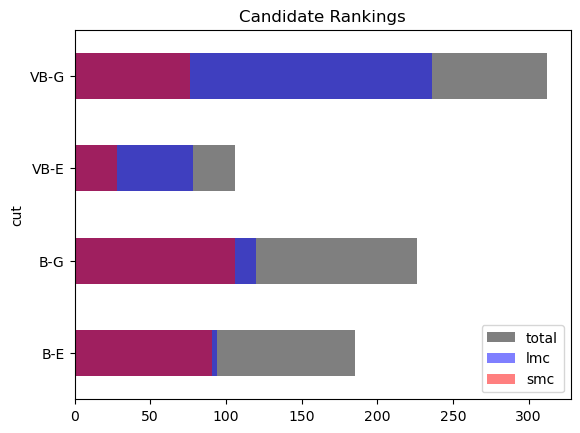

In [3]:
# Get the indices of stars that are brighter than Ylva's models 
bright_cutoff = 14
# Calculate in all UV filters in case one is missing
index_bright_uv = list(df[(df['uvm2_dered'] < bright_cutoff)].index) + list(df[(df['uvw2_dered'] < bright_cutoff)].index) + list(df[(df['uvw1_dered'] < bright_cutoff)].index)
# Drop duplicates 
index_bright_uv = list(set(index_bright_uv))

# Remove these indices from the catalog
df = df.drop(index_bright_uv).reset_index(drop=True)

print('Stars brighter than Stripped Star models')
print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',len(index_bright_uv))
check_stars(df)


# Get the indices of stars that are brighter than Ylva's models 
faint_cutoff = 19
# Calculate in all UV filters in case one is missing
index_faint_uv = list(df[(df['uvm2_dered'] > faint_cutoff)].index) + list(df[(df['uvw2_dered'] > faint_cutoff)].index) + list(df[(df['uvw1_dered'] > faint_cutoff)].index)
# Drop duplicates 
index_faint_uv = list(set(index_faint_uv))

# Remove these indices from the catalog
df = df.drop(index_faint_uv).reset_index(drop=True)

print('Stars fainter in UV than 19 mag')
print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',len(index_faint_uv))
check_stars(df)


print('Stars with mag error within 5sigma')
# If mag error is above our limit set both mag and mag error to 0
max_mag_err = 0.217

mag_cols = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
error_cols = ['uvw2_err','uvm2_err','uvw1_err','e_U','e_B','e_V','e_I']
color_cols = [['uvw2 - b','uvw2 - v','uvw2 - i'],
                 ['uvm2 - b','uvm2 - v','uvm2 - i'],
                 ['uvw1 - b','uvw1 - v','uvw1 - i'],
                 ['u','u','u'],
                 ['uvw2 - b','uvm2 - b','uvw1 - b'],
                 ['uvw2 - v','uvm2 - v','uvw1 - v'],
                 ['uvw2 - i','uvm2 - i','uvw1 - i']]
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']

for mag,err,color in zip(mag_cols,error_cols,color_cols):
    # Columns we want to set to nan
    cols = [mag,err] + color 
    # We don't calculate color for U
    if mag == 'U_dered':
        cols = [mag,err]
        
    # If the mag is above the mag error, set the mag, error, and color columns to nan. 
    df.loc[df[err] > max_mag_err,cols] = np.nan

# Convert 0's back to NaNs 
df = df.replace(0,np.nan)

# Calculate how many nans exist in a row 
n_mag_err = df[mag_cols].isna().sum(axis=1)

# If all 7 mag columns are 0 drop
print(f'How many we lost because all magnitudes had high errors: ',df[(n_mag_err == 7)].shape[0])
df = df[~(n_mag_err == 7)].reset_index(drop=True)

# Recalculate n_blue 
n_blue = df[color_labels].isin(['blue']).sum(axis=1)
df['n_blue_initial'] = df['n_blue']
df['n_blue'] = n_blue

# if n_blue is now 0 then drop it 
print(f'How many we lost because all blue colors were associated with high magnitude errors: ',df[df['n_blue'] == 0].shape[0])
df = df[df['n_blue'] != 0].reset_index(drop=True)

print(f'How many we have: ',df.shape[0])
check_stars(df)

optical_columns = ['U_dered','B_dered','V_dered','I_dered']
uv_columns = ['uvw2_dered','uvm2_dered','uvw1_dered']

enough_points = []
for ind,row in df.iterrows():
    # How many optical mags are there
    n_optical = row[optical_columns].count()
    # How many UV mags are there 
    n_uv = row[uv_columns].count()
    # Need two in both 
    if n_optical >= 3 and n_uv >= 2: 
        enough_points.append(ind)

print('Stars without enough magnitudes in UV and Optical')
print(f'How many we have: ',len(enough_points))
print(f'How many we lost: ',df.shape[0] - len(enough_points))

df = df[df.index.isin(enough_points)].reset_index(drop=True)        
check_stars(df)

mag_reduced_df = df.copy()

# Save
print('1_MagnitudeReductions Completed')

# Make a key
df['key'] = np.arange(df.shape[0])

# Rename filters for simplicity, we can rename them back at the end
df = df.rename(columns={'uvw2_dered':'w2','uvm2_dered':'m2','uvw1_dered':'w1',
                                          'U_dered':'u','B_dered':'b','V_dered':'v','I_dered':'i',
                                          'uvw2 - b':'w2 - b', 'uvw2 - v':'w2 - v', 'uvw2 - i':'w2 - i',
                                          'uvw1 - b':'w1 - b', 'uvw1 - v':'w1 - v', 'uvw1 - i':'w1 - i', 
                                          'uvm2 - b':'m2 - b', 'uvm2 - v':'m2 - v', 'uvm2 - i':'m2 - i'})

# Select keys
optical_columns = ['u','b','v','i']
uv_columns = ['w2','m2','w1']
color_columns = ['w2 - b', 'w2 - v', 'w2 - i',
                'm2 - b', 'm2 - v', 'm2 - i',
                'w1 - b', 'w1 - v', 'w1 - i']

# Make sure we have all the discovery stars except Star 15 (and now Star 19) which we lost in the last notebook 
def check_stars(df):
    # Make sure we have all the discovery stars 
    discovery_names = ['Star_1','Star_2','Star_3','Star_4','Star_5','Star_6','Star_7','Star_8','Star_9','Star_10','Star_11','Star_12','Star_13','Star_14','Star_16','Star_17','Star_18','Star_20','Star_21','Star_22','Star_23','Star_24','Star_25']
    c = 0
    for star in discovery_names:
        if star not in df.discovery_name.unique():
            print (star)
            c += 1
    if c == 0:
        print ("All Remaining Discovery Stars After Magnitude Reductions Have Been Found")

# Print how many stars we have
print("How many stars we have: ",df.shape[0])

# Read in synthetic photometry
names = ['Minit_strip','M_MS','frac_MS','U','B','V','R','I','UVM2','UVW2','UVW1']

synth_photom_file = '/home/bethany/Projects/0_Data/1_Models/Stripped_Stars/photometry_CMFGEN_composites.txt'
sf = pd.read_csv(synth_photom_file,comment='#',delimiter='\t',names=names)

# Make dictionary of the minimum and maximum difference between different filters
max_mag_err = 0.217
min_diff = {'w2 - m2': np.min(sf.UVW2-sf.UVM2) - max_mag_err,
            'm2 - w1': np.min(sf.UVM2-sf.UVW1) - max_mag_err,
            'w1 - u': np.min(sf.UVW1-sf.U) - max_mag_err,
            'u - b': np.min(sf.U-sf.B) - max_mag_err,
            'b - v': np.min(sf.B-sf.V) - max_mag_err,
            'v - i': np.min(sf.V-sf.I) - max_mag_err,
            # Additional UV - Optical Filters
            'w1 - b': np.min(sf.UVW1-sf.B) - max_mag_err,
            'm2 - u': np.min(sf.UVM2-sf.U) - max_mag_err,
            'm2 - b': np.min(sf.UVM2-sf.B) - max_mag_err,
           }

max_diff = {'w2 - m2': np.max(sf.UVW2-sf.UVM2) + max_mag_err,
            'm2 - w1': np.max(sf.UVM2-sf.UVW1) + max_mag_err,
            'w1 - u': np.max(sf.UVW1-sf.U) + max_mag_err,
            'u - b': np.max(sf.U-sf.B) + max_mag_err,
            'b - v': np.max(sf.B-sf.V) + max_mag_err,
            'v - i': np.max(sf.V-sf.I) + max_mag_err,
            # Additional UV - Optical Filters
            'w1 - b': np.max(sf.UVW1-sf.B) + max_mag_err,
            'm2 - u': np.max(sf.UVM2-sf.U) + max_mag_err,
            'm2 - b': np.max(sf.UVM2-sf.B) + max_mag_err,
           }

check_stars(df)

size = df.shape[0]
# Get rows where only one filter made it blue
blue_in_one = df[df['n_blue'] <= 3].copy()

# Compare adjacent mags to see if the filter is super different from the sed 
bad_filter_index = []

# For the filters on the ends, uvw2 and i, you only need to compare one color
filter_1 = ['w2','v']
filter_2 = ['m2','i']
filter_color = ['w2','i']

for f1, f2, fc in zip(filter_1,filter_2,filter_color):
    # Get all color combos for a specific filter 
    # For example, get all the w2 - b, w2 - v, w2 - i for w2
    c = list(filter(lambda x: fc in x,color_columns))
    # Get everything where the respective filter is blue 
    blue = blue_in_one[(blue_in_one[c[0]] == 'blue') & (blue_in_one[c[1]] == 'blue') & (blue_in_one[c[2]] == 'blue')]
    # Calculate the difference between the filter and its adjacent filter
    diff = blue[f'{f1}'] - blue[f'{f2}']
    # Compare to synthetic photometry      
    bad = blue[(diff > max_diff[f'{f1} - {f2}']) | (diff < min_diff[f'{f1} - {f2}']) ]
    bad_keys = bad['key'].values
    print('')
    bad_filter_index.append(bad_keys)

# For all the other filters you need to compare whats on the left and the right 
filters = ['w2','m2','w1','u','b','v','i']          

for i in np.arange(6):
    # Skip the ends
    if filters[i] == 'w2' or filters[i] == 'i' or filters[i] == 'u':
        continue
    # The filter you're considering
    f0 = filters[i]
    # The previous filter
    f1 = filters[i-1]
    # The next filter
    f2 = filters[i+1]
    print(f'Solving {f0}')
    # Get colors 
    c = list(filter(lambda x: f0 in x,color_columns))
    print(f'Checking Colors: {c}')
    # Get everything where the respective filter is blue 
    blue = blue_in_one[(blue_in_one[c[0]] == 'blue') & (blue_in_one[c[1]] == 'blue') & (blue_in_one[c[2]] == 'blue')] 
    # Calculate differences
    print(f'Calculating difference for: "{f1} - {f0}"')
    diff_1 = blue[f'{f1}'] - blue[f'{f0}']
    print(f'Calculating difference for: "{f0} - {f2}"')
    diff_2 = blue[f'{f0}'] - blue[f'{f2}']
    # Calculate synthetic differences
    synth_1 = [min_diff[f'{f1} - {f0}'], max_diff[f'{f1} - {f0}']]
    synth_2 = [min_diff[f'{f0} - {f2}'], max_diff[f'{f0} - {f2}']]
    # Compare                    The Left                                        The Right
    bad = blue[(diff_1 < synth_1[0]) | (diff_1 > synth_1[1]) | (diff_2 < synth_2[0]) | (diff_2 > synth_2[1])]
    bad_keys = bad['key'].values
    if len(bad_keys) == 0: 
        print('Check Filter')
        print(f0)
    print('')
    # Append
    bad_filter_index.append(bad_keys)
    
# Flatten the index
bad_filter_index = [item for row in bad_filter_index for item in row]
# Sort the index 
bad_filter_index = np.sort(bad_filter_index)

df = df[~df['key'].isin(bad_filter_index)]

print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',size-df.shape[0])
check_stars(df)

size = df.shape[0]
# Mismatch #1: UV and Optical components of SED are fairly flat but there's a large discrepency between them

# If all the mags are within the max allowed error, we consider it 'flat'
flat_std = max_mag_err
flat_mag_jump = 1. + max_mag_err

flat_jump_index = []

for ind,row in df.iterrows():
    uv = row[uv_columns].values
    opt = row[optical_columns].values
    
    if np.nanstd(uv) < flat_std and np.nanstd(opt) < flat_std:
        # If you have a flat sed look for a big jump 
        if np.abs(np.nanmean(uv) - np.nanmean(opt)) > flat_mag_jump:
            flat_jump_index.append(row['key'])
            
# Remove from sample 
df = df[~df['key'].isin(flat_jump_index)]

print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',size - df.shape[0])
check_stars(df)    

size = df.shape[0]
# Mismatch #2: Check either UVW1 or UVW2 against U or B to see if there's a large jump 
def not_in_bin(row,uv_filter,optical_filter):
    diff = row[uv_filter] - row[optical_filter]
    if diff < min_diff[f'{uv_filter} - {optical_filter}'] or diff > max_diff[f'{uv_filter} - {optical_filter}']:
        return True
    return False

def exists(row,Filter):
    return np.isfinite(row[Filter])

mismatch_index = []

for i,r in df.iterrows():

    # Ideal case: UVW1, U, and B, all exist. 
    if exists(r,'w1') and exists(r,'u') and exists(r,'b'):
        # If UVW1 - U and UVW1 - B are both not in synthetic bin then drop
        if not_in_bin(r,'w1','u') and not_in_bin(r,'w1','b'):
            mismatch_index.append(r['key'])
    
    # UVW1 and U exist, but B does not.
    if exists(r,'w1') and exists(r,'u') and not exists(r,'b'):
        # If UVW1 - U is not in synthetic bin then drop
        if not_in_bin(r,'w1','u'):
            mismatch_index.append(r['key'])
            
    # UVW1 and B exist, but U does not. 
    if exists(r,'w1') and exists(r,'b') and not exists(r,'u'):
        # If UVW1 - B is not in synthetic bin then drop
        if not_in_bin(r,'w1','b'):
            mismatch_index.append(r['key'])    
    
    # UVM2, U, and B, exist, but UVW1 does not. 
    if exists(r,'m2') and exists(r,'u') and exists(r,'b') and not exists(r,'w1'):
        # If UVM2 - U and UVM2 - B are both not in synthetic bin then drop
        if not_in_bin(r,'m2','u') and not_in_bin(r,'m2','b'):
            mismatch_index.append(r['key']) 
            
    # UVM2 and U exist, but UVW1 and B do not.
    if exists(r,'m2') and exists(r,'u') and not exists(r,'w1') and not exists(r,'b'):
        # If UVM2 - U is not in synthetic bin then drop
        if not_in_bin(r,'m2','u'):
            mismatch_index.append(r['key'])     

    # UVM2 and B exist, but UVW1 and U do not. 
    if exists(r,'m2') and exists(r,'b') and not exists(r,'w1') and not exists(r,'u'):
        # If UVM2 - B is not in synthetic bin then drop
        if not_in_bin(r,'m2','b'):
            mismatch_index.append(r['key'])    
            
df = df[~df['key'].isin(mismatch_index)]

print(f'How many we have: ',df.shape[0])
print(f'How many were categorized as mismatched: ',size - df.shape[0])
check_stars(df)  

size = df.shape[0]
red_index = []

for ind, row in df.iterrows():
    y = np.array(row[optical_columns].values).astype(float)
    # Calculate derivatives
    d = np.diff(y)
    # If derivatives are negative 2 or more times (indicating positive slope for mags) then save
    n = len(d[np.isfinite(d) & (d<0)])
    if n >= 2:
        red_index.append(row['key'])

df = df[~df['key'].isin(red_index)].reset_index(drop=True)

print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',size-df.shape[0])
check_stars(df)  


vf = df.copy()

def not_in_bin(row,uv_filter,optical_filter):
    diff = row[uv_filter] - row[optical_filter]
    if diff < min_diff[f'{uv_filter} - {optical_filter}'] or diff > max_diff[f'{uv_filter} - {optical_filter}']:
        return True
    return False

variable_index = []
filters = ['w2','m2','w1','u','b','v','i']
for ind,row in vf.iterrows():
    # Get the sed
    sed = row[filters]
    # Take the derivatives         
    div = np.abs(np.diff(sed))
    # Compare to allowed differences 
    compare = [not_in_bin(row,f1,f2) for f1,f2 in zip(filters[:-1],filters[1:])]
    # Where do the bumps occur? 
    loc = np.where(compare)[0]
    # How many bumps are there?
    n_bumps = len(loc)
    if n_bumps == 0: 
        continue
    # If there are three or more bumps it's automatically variable 
    if n_bumps >= 3:
        variable_index.append(row.key)
        
    # The location of the bumps tell us which filters are involved 
    # Zero out colors related to that filter and see if it is still blue 
    # For instance: W2 - M2 is the first element in the div array
        
    # If there are two bumps and they are next to each other: 
    if n_bumps == 2 and (loc[1] == loc[0] - 1 or loc[1] == loc[0] + 1): 
        # UVM2 is connected
        if loc[0] == 0 and loc[1] == 1:
            vf.loc[vf.key==row.key,color_columns[1]] = np.nan
        # UVW1 is connected
        if loc[0] == 1 and loc[1] == 2:
            vf.loc[vf.key==row.key,color_columns[2]] = np.nan
        # B is connected, zero out related colors
        if loc[0] == 3 and loc[1] == 4:
            vf.loc[vf.key==row.key,color_columns[4]] = np.nan
        # V is connected, zero out related colors
        if loc[0] == 4 and loc[1] == 5:
            vf.loc[vf.key==row.key,color_columns[5]] = np.nan
    # If there is one bump or they are not connected
    else:
        # UVW2 and UVM2 
        if 0 in loc:
            vf.loc[vf.key==row.key,color_columns[0] + color_columns[1]] = np.nan
        # UVM2 and UVW1 
        if 1 in loc: 
            vf.loc[vf.key==row.key,color_columns[1] + color_columns[2]] = np.nan
        # UVW1 and U (we don't color by U)
        if 2 in loc: 
            vf.loc[vf.key==row.key,color_columns[2]] = np.nan
        # U and B (we don't color by U)
        if 3 in loc: 
            vf.loc[vf.key==row.key,color_columns[4]] = np.nan
        # B and V 
        if 4 in loc: 
            vf.loc[vf.key==row.key,color_columns[4] + color_columns[5]] = np.nan
        # V and I 
        if 5 in loc: 
            vf.loc[vf.key==row.key,color_columns[5] + color_columns[6]] = np.nan
            
# Recalculate to see what is still blue 
n_blue = vf[color_columns].isin(['blue']).sum(axis=1)

# Find out which rows are no longer blue 
nolongerblue = vf.loc[n_blue == 0,'key']

# Combine Variable Index and No Longer Blue, Remove Duplicates
variable_index = np.sort(np.unique(np.append(variable_index,nolongerblue)))

# Drop variables
df = df[~df['key'].isin(variable_index)]
print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',len(variable_index))
check_stars(df)  


# Change all color combos with 'i' to not be blue. 
i_df = df.copy()

for color in ['w2 - i','w1 - i', 'm2 - i']:
    i_df[color] = i_df[color].replace('blue',np.nan)

# Recalculate to see what is still blue 
n_blue = i_df[color_columns].isin(['blue']).sum(axis=1)

# Find out which rows are no longer blue 
bad_i_index = i_df.loc[n_blue == 0,'key']

# Drop variables
df = df[~df['key'].isin(bad_i_index)]
print(f'How many we have: ',df.shape[0])
print(f'How many we lost: ',len(bad_i_index))
check_stars(df)  

#Reread in and calculate the number of jumps for everything: 
df = mag_reduced_df.copy() 

# Rename filters for simplicity, we can rename them back at the end
df = df.rename(columns={'uvw2_dered':'w2','uvm2_dered':'m2','uvw1_dered':'w1',
                                          'U_dered':'u','B_dered':'b','V_dered':'v','I_dered':'i',
                                          'uvw2 - b':'w2 - b', 'uvw2 - v':'w2 - v', 'uvw2 - i':'w2 - i',
                                          'uvw1 - b':'w1 - b', 'uvw1 - v':'w1 - v', 'uvw1 - i':'w1 - i', 
                                          'uvm2 - b':'m2 - b', 'uvm2 - v':'m2 - v', 'uvm2 - i':'m2 - i'})

#Recalculate the number of bumps for this sample and save it as a column: 
filters = ['w2','m2','w1','u','b','v','i']
n_bumps = []
for ind,row in df.iterrows():
    # Get the sed
    sed = row[filters]
    # Take the derivatives         
    div = np.abs(np.diff(sed))
    # Compare to allowed differences 
    compare = [not_in_bin(row,f1,f2) for f1,f2 in zip(filters[:-1],filters[1:])]
    # Where do the bumps occur? 
    loc = np.where(compare)[0]
    # How many bumps are there?
    n_bumps.append(len(loc))


# Do any cuts overlap?
drop_index = [bad_filter_index , flat_jump_index , mismatch_index , red_index , variable_index , bad_i_index]
drop_name = ['bad_filter','flat_jump','mismatch','red','variable','bad_i']

# Re-Read in magnitude reduced files 
df = mag_reduced_df.copy() 

# Make a key
df['key'] = np.arange(df.shape[0])

# Add the number of bumps to the dataframe
df['n_bumps'] = n_bumps


# Make a cut column 
df['cut'] = ''

# Fill the cut column 
for index, name in zip(drop_index,drop_name):
    df.loc[df['key'].isin(index),'cut'] = name

print(f'{df[df.cut == ""].shape[0]} stars remaining')
print(f'{df[df.cut != ""].shape[0]} stars cut')
print(df[df.cut == ""].galaxy.value_counts())

sedreductions_df = df.copy()
print('2_SEDReductions Completed')


# Turn empty spaces in df into nans 
df = sedreductions_df.copy()
df = df.replace('',np.nan)
df[df.cut.isna()]

# Drop anything that was cut from the sample
df = df[df.cut.isna()]

print('Initial Size: ', df.shape[0])

# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset the index
df = df.reset_index(drop=True)

# Replace number columns that have nans with 0
nan_cols = ['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5','uvw2_num1', 'uvm2_num1', 'uvw1_num1']
[df.fillna({col:0}, inplace=True) for col in nan_cols]

# Add a column taking maximum number of neighbors within 2.5"
df['max_2p5'] = df[['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5']].max(axis=1)

# Add a column taking maximum number of neighbors are within 1"
df['max_1'] = df[['uvw2_num1', 'uvm2_num1', 'uvw1_num1']].max(axis=1)

# Add a column taking minimum distance of closest stars:
df['closest'] = df[['uvw2_closest_min', 'uvm2_closest_min', 'uvw1_closest_min']].min(axis=1)

# Add a column taking minimium and average of the UV flux fractions:
df['ff_min'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].min(axis=1)
df['ff_avg'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].mean(axis=1)

# Add a column for how many filters are present 
sed_columns = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
df['n_filters'] = df[sed_columns].notna().sum(axis=1)

# Average distance from zams 
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']
distance_labels = [f'{color} distance' for color in color_labels]
df['avg_zdis'] = df[distance_labels].mean(axis=1)

# Average distance weighted by errors (zsigma)
for col in color_labels:
    df[f'{col} zsigma'] = df[f'{col} distance'] / df[f'{col} err']
zsigma_labels = [f'{color} zsigma' for color in color_labels]
df['avg_zsigma'] = df[zsigma_labels].mean(axis=1)

# Require that the source is blue in at least three color combinations
df = df[df.n_blue>3]

# Require that the flux fraction is above 10%
df = df[df.ff_avg>0.1]

# If the closest source is within 2.5", require that the flux fraction be above 25%
df = df.drop(df[(df.closest<2.5) & (df.ff_avg<0.25)].index)

df = df.reset_index(drop=True)

# Replace the key 
df['key'] = np.arange(len(df))

print('After initial cuts: ', df.shape[0])

ff_cut = 0.4
zdis_cut = -0.4
bump_cut = 2
nfilter_cut = 6

df.loc[df.avg_zdis < zdis_cut, 'cut'] = 'VB-G'

df.loc[(df.avg_zdis < zdis_cut) & 
       (df.ff_avg > ff_cut) &
       (df.n_bumps <= 1) & 
       (df.n_filters >= nfilter_cut), 'cut'] = 'VB-E'

df.loc[df.avg_zdis >= zdis_cut, 'cut'] = 'B-G'

df.loc[(df.avg_zdis >= zdis_cut) & 
       (df.ff_avg > ff_cut) &
       (df.n_bumps <= 1) & 
       (df.n_filters >= nfilter_cut), 'cut'] = 'B-E'



# Percentage in each
print('Av in the SMC: ', smc_Av)
print('Candidates in the SMC: ', df[df.galaxy == 'smc'].shape[0])
print('Av in the LMC: ', lmc_Av)
print('Candidates in the LMC: ', df[df.galaxy == 'lmc'].shape[0]) 
print('Total Percentages: ')
print(df.cut.value_counts(normalize=True).sort_index())
print(' ')
print('Total Values: ')
print(df.cut.value_counts().sort_index())
print(' ')
print('LMC Values: ')
print(df[df.galaxy == 'lmc'].cut.value_counts().sort_index())
print(' ')
print('SMC Values: ')
print(df[df.galaxy == 'smc'].cut.value_counts().sort_index())


plt.title('Candidate Rankings')
df.cut.value_counts().sort_index().plot.barh(color='k',alpha=0.5,label='total');
df[df.galaxy == 'lmc'].cut.value_counts().sort_index().plot.barh(color='b',alpha=0.5,label='lmc');
df[df.galaxy == 'smc'].cut.value_counts().sort_index().plot.barh(color='r',alpha=0.5,label='smc')
plt.legend();

In [4]:
# # Run this just for ones that are candidates regarless of extinction (Av=0)
# # Import candidate list 
# if lmc_Av == 0 and smc_Av == 0:
#     directory = '/home/bethany/Projects/0_Data/0_SUMS_Catalogs/CandidateCatalog/'
#     candidates = pd.read_csv(directory+'3_stripped_star_candidates.csv')
#     candidates['blue_with_no_extinction'] = 'no'
#     # Crossmatch df with candidates and save a column in candidates
#     cand_co = SkyCoord(ra=candidates.ra,dec=candidates.dec,unit='deg')
#     for ind, row in df.iterrows():
#         df_co = SkyCoord(ra=row.ra,dec=row.dec,unit='deg')
#         sep = df_co.separation(cand_co).arcsecond
#         if np.min(sep) < 0.1:
#             candidates.loc[np.argmin(sep),'blue_with_no_extinction'] = 'yes'
#         else:
#             print(sep)

#     # Save the candidates
#     candidates.to_csv(directory+'3_stripped_star_candidates_vary_extinction.csv',index=False)

#     # What type of cut do the ones robust against extinction have?
#     print(candidates.loc[candidates['blue_with_no_extinction'] == 'yes','cut'].value_counts())

In [5]:
# import pandas as pd 
# 
# og_df = pd.read_csv(directory+'3_stripped_star_candidates.csv')

# df['blue_with_no_extinction'].value_counts()

In [6]:
directory = '/home/bethany/Projects/0_Data/0_SUMS_Catalogs/CandidateCatalog/'
df.to_csv(directory+'fiducial_extinction.csv',index=False)

In [7]:
#og_df#[og_df.col1 == 11293]